In [1]:
# Importamos las librerías necesarias de uso
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## Planteamos modelo XOR puramente con python

In [2]:
# Generamos la tabla de entradas
X = np.array([
    [0,0],
    [0,1],
    [1,0],
    [1,1]
], dtype=np.float32)
y = np.array([0,1,1,0], dtype=np.float32)

In [3]:
# En este caso, vamos a considerar que incluyen los biases para que se simplifique el cálculo vectorial
X = np.append(X, np.ones(shape=(X.shape[0],1)), axis=1)
X

array([[0., 0., 1.],
       [0., 1., 1.],
       [1., 0., 1.],
       [1., 1., 1.]])

In [4]:
# Vamos a considerar el shape de X para definir los pesos a utilizar
n, m = X.shape
n, m

(4, 3)

In [5]:
# Vamos a generar los pesos y los inicializamos random
w1_1 = np.random.random(size=(m,1))
w1_2 = np.random.random(size=(m,1))
w2_1 = np.random.random(size=(m,1))

In [6]:
# Para corroborar los cálculos, vamos a usar la primera fila de X
# Calculamos entonces la primera capa
z1_1 = X[0,:] @ w1_1
z1_2 = X[0,:] @ w1_2
print(f"Los valores de los z son: {z1_1} y {z1_2}")

Los valores de los z son: [0.88583451] y [0.58848396]


In [7]:
# Debemos utilizar una función que no linealice esta salida, ya que no tendría sentido el planteo
# Podemos utilzar para esta función una sigmoide como activación
def sigmoide(z):
    return 1/(1+np.exp(-z))

In [8]:
# Utilizamos esta función de activación sobre los z
a1_1 = sigmoide(z1_1)
a1_2 = sigmoide(z1_2)
print(f"Los valores de los 1 son: {a1_1} y {a1_2}")

Los valores de los 1 son: [0.70802981] y [0.64301722]


In [9]:
# Para calcular la segunda capa, debemos generar un vector auxiliar con estos a y sumamos el 1 del bias
x_aux = np.array([a1_1[0], a1_2[0], 1], dtype=np.float32) # se usa el índice 0 para que se usen los números y no los vectores
x_aux.shape

(3,)

In [10]:
# Con este vector auxiliar, planteamos entonces la segunda capa
z2_1 = x_aux @ w2_1
print(f'El valor de última salida es: {z2_1}')

El valor de última salida es: [0.3282829]


In [11]:
# Como este z no pasa por la sigmoide en esta capa, es igual a a, quien a su vez es el valor predicho
y_pred = z2_1[0] # consideramos nuevamente el valor no el array
print(f'Este es el valor de la predicción de y: {y_pred}')

Este es el valor de la predicción de y: 0.32828290128951987


In [12]:
# Para calcular el error, debemos restar este valor en el valor verdadero (residuo) y luego aplicar el cuadrado (por MSE)
residuo = y[0] - y_pred # usamos el mismo índice de X
error = np.square(residuo)
print(f'Vemos el residuo generado y el error: {residuo} y {error}')

Vemos el residuo generado y el error: -0.32828290128951987 y 0.10776966327906465


In [13]:
# Como ya tenemos el valor de error generado, podríamos plantear el backpropagation
dw1_1 = (-2*(1/n)*residuo*w2_1[0]*a1_1[0]*(1-a1_1[0])*X[0,:]).reshape(-1,1)
dw1_2 = (-2*(1/n)*residuo*w2_1[1]*a1_2[0]*(1-a1_2[0])*X[0,:]).reshape(-1,1)
dw2_1 = (-2*(1/n)*residuo*x_aux).reshape(-1,1)
print(f'Vemos los resultados de los gradientes -> \ndw1_2:{dw1_2}, \ndw1_1:{dw1_1} y \ndw2_1:{dw2_1}')

Vemos los resultados de los gradientes -> 
dw1_2:[[0.        ]
 [0.        ]
 [0.00161314]], 
dw1_1:[[0.        ]
 [0.        ]
 [0.00310596]] y 
dw2_1:[[0.11621704]
 [0.10554578]
 [0.16414145]]


In [14]:
# Actualizamos los valores de los wights, para ello, necesitamos definir un learning rate de 0.1
lr = 0.1
w1_1 -= lr * dw1_1 
w1_2 -= lr * dw1_2
w2_1 -= lr * dw2_1
print(f'Vemos los resultados de los pesos actualizados -> \nw1_1:{w1_1}, \nw1_2:{w1_2} y \nw2_1:{w2_1}')

Vemos los resultados de los pesos actualizados -> 
w1_1:[[0.99786639]
 [0.70285211]
 [0.88552391]], 
w1_2:[[0.8468673 ]
 [0.49904643]
 [0.58832264]] y 
w2_1:[[0.07991331]
 [0.0322593 ]
 [0.21952917]]


In [15]:
# Ahora que tenemos los nuevos valores de pesos, podemos realizar una función que genere los MSE usando SGD
# Se deben generar un número de epochs para la iteración (tomaremos 20000)
def fit_XOR(X: np.ndarray, y: np.ndarray, lr=0.1, epochs=20000):
    # Inicializamos las listas vacías de MSE y resultados
    lista_MSE = []
    
    # Añadimos la columna de unos
    X = np.append(X, np.ones(shape=(X.shape[0],1)), axis=1)
    
    # Definimos los valores de las dimensiones a utilizar
    n, m = X.shape
    
    # Inicializamos los valores random de los pesos
    w1_1 = np.random.random(size=(m,1))
    w1_2 = np.random.random(size=(m,1))
    w2_1 = np.random.random(size=(m,1))
    
    # Iteramos el número de épocas
    for epoch in range(epochs):
        # Generamos la mezcla de los índices (ya que se usa SGD)
        idx = np.random.permutation(n)
        X = X[idx]
        y = y[idx]
        
        # Inicializamos en valor 0 de MSE (que se irá actualizando)
        MSE = 0
        
        # Iteramos sobre el rango de X
        for i in range(n):
            # Calculamos los z de la primera capa
            z1_1 = X[i,:] @ w1_1
            z1_2 = X[i,:] @ w1_2
            
            # Los pasamos por la función de activación
            a1_1 = sigmoide(z1_1)
            a1_2 = sigmoide(z1_2)
            
            # Calculamos el x auxiliar
            x_aux = np.array([a1_1[0], a1_2[0], 1], dtype=np.float32)
            
            # Plantemos el z de la segunda capa
            z2_1 = x_aux @ w2_1
            
            # Calculamos la predicción
            y_pred = z2_1[0]
            
            # Calculamos el residuo y el error. Lo actualizamos al MSE
            residuo = y[i] - y_pred
            error = np.square(residuo)
            MSE += error
            
            # Calculamos los gradientes del backpropagation
            dw1_1 = (-2*(1/n)*residuo*w2_1[0]*a1_1[0]*(1-a1_1[0])*X[i,:]).reshape(-1,1)
            dw1_2 = (-2*(1/n)*residuo*w2_1[1]*a1_2[0]*(1-a1_2[0])*X[i,:]).reshape(-1,1)
            dw2_1 = (-2*(1/n)*residuo*x_aux).reshape(-1,1)
            
            # Actualizamos los valores de los pesos
            w1_1 -= lr * dw1_1
            w1_2 -= lr * dw1_2
            w2_1 -= lr * dw2_1
            
        # Agregamos el valor a la lista
        lista_MSE.append(MSE/4)
        
        # Imprimimos algunos valores para ver el entrenamiento
        if (epoch % (epochs/10)) == 0:
            print("epoch: ", epoch, ", MSE: ", MSE)
    
    return lista_MSE

In [16]:
# Inicializamos los valores de X y y
X = np.array([
    [0,0],
    [0,1],
    [1,0],
    [1,1]
], dtype=np.float32)
y = np.array([0,1,1,0], dtype=np.float32)
# Hacemos una prueba de la función
resultados = fit_XOR(X, y)

epoch:  0 , MSE:  6.192982509578505
epoch:  2000 , MSE:  0.05370128915648016
epoch:  4000 , MSE:  1.6148385551018535e-11
epoch:  6000 , MSE:  3.1251435449602456e-15
epoch:  8000 , MSE:  2.9111637325713993e-15
epoch:  10000 , MSE:  2.7664455513759784e-15
epoch:  12000 , MSE:  3.0975866629658816e-15
epoch:  14000 , MSE:  8.241141397490854e-15
epoch:  16000 , MSE:  2.9952677462944413e-15
epoch:  18000 , MSE:  2.8606688621969163e-15


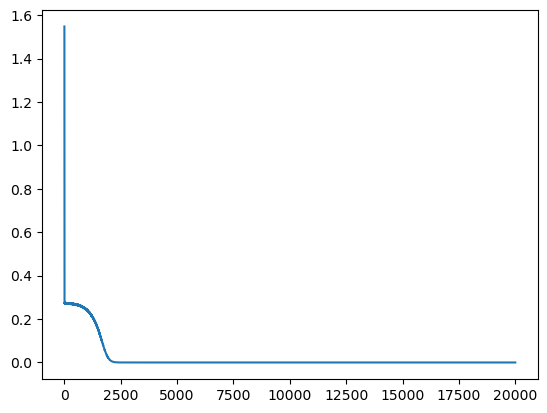

In [17]:
# Ploteamos los resultados
plt.plot(resultados);

## Planteamos XOR con optimizador MiniBatch y momento de primer orden

In [66]:
# Ahora que tenemos los nuevos valores de pesos, podemos realizar una función que genere los MSE usando MiniBatch
# Se deben generar un número de epochs para la iteración (tomaremos 5000)
def fit_XOR_miniBatch(X: np.ndarray, y: np.ndarray, lr=0.1, epochs=5000, epsilon=0.2, batch_size=2):
    # Inicializamos las listas vacías de MSE y resultados
    lista_MSE = []
    
    # Definimos los valores de las dimensiones a utilizar
    n, m = X.shape
        
    # Inicializamos los valores random de los pesos
    w1_1 = np.random.random(size=3)
    w1_2 = np.random.random(size=3)
    w2_1 = np.random.random(size=3)
    #print(f'dimension w1_1:{w1_1.shape}')
   
    # Generamos valores random de los vs
    v1_1 = np.random.random(size=3)
    v1_2 = np.random.random(size=3)
    v2_1 = np.random.random(size=3)
   
    # Iteramos el número de épocas
    for epoch in range(epochs):
        # Generamos la mezcla de los índices
        idx = np.random.permutation(n)
        X = X[idx]
        y = y[idx]
        
        # Inicializamos en valor 0 de MSE (que se irá actualizando)
        MSE = 0
        
        # Iteramos sobre el rango de X
        for batch in range(0, n, batch_size):          
            # Generamos los datos del batch
            X_batch = X[idx[batch:batch+batch_size]]
            y_batch = y[idx[batch:batch+batch_size]]
            
            # Añadimos la columna de unos
            X_batch = np.append(X_batch, np.ones(shape=(X_batch.shape[0],1)), axis=1)
            #print(f'dimension X_batch:{X_batch.shape} and y_batch: {y_batch.shape}')   

            # Calculamos los z de la primera capa
            z1_1 = X_batch @ w1_1.T
            z1_2 = X_batch @ w1_2.T
            #print(f'dimension z1_1:{z1_1.shape} and z1_2: {z1_2.shape}')

            # Los pasamos por la función de activación
            a1_1 = sigmoide(z1_1).reshape(-1,1)
            a1_2 = sigmoide(z1_2).reshape(-1,1)
            #print(f'dimension a1_1:{a1_1.shape} and a1_2: {a1_2.shape}')
            
            # Calculamos el x auxiliar
            x_aux = np.concatenate([a1_1, a1_2, np.ones(shape=(2,1))], axis=1)
            #print(f'dimension x_aux:{x_aux.shape}')
            
            # Plantemos el z de la segunda capa
            z2_1 = x_aux @ w2_1
            #print(f'dimension z2_1:{z2_1.shape}')
            
            # Calculamos la predicción
            y_pred = z2_1
            #print(f'dimension y_pred:{y_pred.shape}')
            
            # Calculamos el residuo y el error. Lo actualizamos al MSE
            residuo = y_batch - y_pred
            #print(f'dimension residuo:{residuo.shape}')
            error = np.square(residuo).mean()
            MSE += error
            #print(f'dimension error:{error.shape}')
            
            # Calculamos los gradientes del backpropagation
            dw2_1 = -2 * residuo.reshape(-1,1) * x_aux
            dw2_1 = dw2_1.mean(axis=0)
            #print(f'dimension dw2_1:{dw2_1.shape}')
            dw1_1 = -2 * residuo.reshape(-1,1) * a1_1 * (1-a1_1) * w2_1[0] * X_batch
            dw1_1 = dw1_1.mean(axis=0)
            #print(f'dimension dw1_1:{dw1_1.shape}')
            dw1_2 = -2 * residuo.reshape(-1,1) * a1_2 * (1-a1_2) * w2_1[1] * X_batch
            dw1_2 = dw1_2.mean(axis=0)
            #print(f'dimension dw1_2:{dw1_2.shape}')

            # Definimos los vs para aplicar momentos de primer orden
            v2_1 = epsilon * v2_1 + lr * dw2_1
            v1_1 = epsilon * v1_1 + lr * dw1_1
            v1_2 = epsilon * v1_2 + lr * dw1_2
           

            # Actualizamos los valores de los pesos
            w1_1 -= v1_1
            w1_2 -= v1_2
            w2_1 -= v2_1
            
        # Agregamos el valor a la lista
        lista_MSE.append(MSE)
        
        # Imprimimos algunos valores para ver el entrenamiento
        if (epoch % (epochs/10)) == 0:
            print("epoch: ", epoch, ", MSE: ", MSE)
    
    return lista_MSE

In [71]:
# Inicializamos los valores de X y y
X = np.array([
    [0,0],
    [0,1],
    [1,0],
    [1,1]
], dtype=np.float32)
y = np.array([0,1,1,0], dtype=np.float32)

# Diferentes epsilons
eps2 = 0.02
eps3 = 0.002

# Hacemos una prueba de la función
resultados_e1 = fit_XOR_miniBatch(X, y)
resultados_e2 = fit_XOR_miniBatch(X, y, epsilon=eps2)
resultados_e3 = fit_XOR_miniBatch(X, y, epsilon=eps3)

epoch:  0 , MSE:  0.6634492543798733
epoch:  500 , MSE:  0.49938561296924633
epoch:  1000 , MSE:  0.4937049590709083
epoch:  1500 , MSE:  0.3843139679682733
epoch:  2000 , MSE:  0.021225924740384407
epoch:  2500 , MSE:  1.787880343053287e-06
epoch:  3000 , MSE:  8.110767827120427e-11
epoch:  3500 , MSE:  4.61525050280729e-15
epoch:  4000 , MSE:  2.397138081199506e-19
epoch:  4500 , MSE:  6.797031156257661e-24
epoch:  0 , MSE:  2.2296082745979455
epoch:  500 , MSE:  0.7008873266093407
epoch:  1000 , MSE:  0.5006246897640803
epoch:  1500 , MSE:  0.5011523930180517
epoch:  2000 , MSE:  0.6516253109832902
epoch:  2500 , MSE:  0.6395680494868542
epoch:  3000 , MSE:  0.5003803009348071
epoch:  3500 , MSE:  0.5001471622531244
epoch:  4000 , MSE:  0.4971478287340533
epoch:  4500 , MSE:  0.5607484478105184
epoch:  0 , MSE:  2.062565266404382
epoch:  500 , MSE:  0.49659075675559644
epoch:  1000 , MSE:  0.22780402912972297
epoch:  1500 , MSE:  1.1787451606625337e-05
epoch:  2000 , MSE:  9.1495776

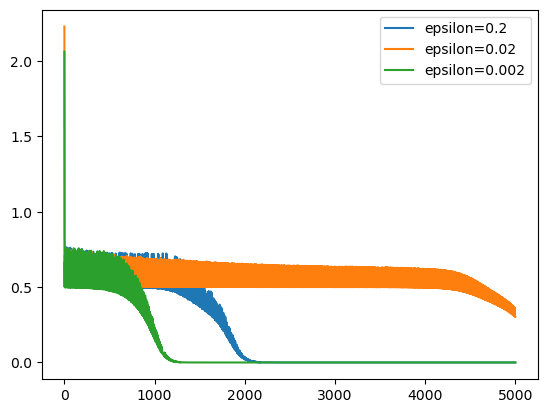

In [72]:
# Ploteamos los resultados
plt.figure()
plt.plot(resultados_e1, label='epsilon=0.2')
plt.plot(resultados_e2, label=f'epsilon={eps2}')
plt.plot(resultados_e3, label=f'epsilon={eps3}')
plt.legend()
plt.show()

- Se ve que dependiendo el valor del epsilon, se modifica el número de epochs necesarios para llegar a cero.

In [81]:
# Inicializamos los valores de X y y
X = np.array([
    [0,0],
    [0,1],
    [1,0],
    [1,1]
], dtype=np.float32)
y = np.array([0,1,1,0], dtype=np.float32)

# Diferentes learning rates
lr2 = 0.01
lr3 = 0.001

# Hacemos una prueba de la función
resultados_lr1 = fit_XOR_miniBatch(X, y, epochs=10000)
resultados_lr2 = fit_XOR_miniBatch(X, y, lr=lr2, epochs=10000)
resultados_lr3 = fit_XOR_miniBatch(X, y, lr=lr3, epochs=10000)

epoch:  0 , MSE:  2.6012275302111787
epoch:  1000 , MSE:  0.5002580006625412
epoch:  2000 , MSE:  0.5008520291389369
epoch:  3000 , MSE:  0.40144730770916515
epoch:  4000 , MSE:  4.75636991038365e-12
epoch:  5000 , MSE:  3.41056616801318e-27
epoch:  6000 , MSE:  2.2001823684679782e-30
epoch:  7000 , MSE:  2.070759876205156e-30
epoch:  8000 , MSE:  2.070759876205156e-30
epoch:  9000 , MSE:  2.2001823684679782e-30
epoch:  0 , MSE:  4.665518564351947
epoch:  1000 , MSE:  0.5112832282878845
epoch:  2000 , MSE:  0.5067734574340483
epoch:  3000 , MSE:  0.46910546630393485
epoch:  4000 , MSE:  0.47059479494465556
epoch:  5000 , MSE:  0.4252134693198728
epoch:  6000 , MSE:  0.4012383211567607
epoch:  7000 , MSE:  0.3743630107492564
epoch:  8000 , MSE:  0.28450322377609855
epoch:  9000 , MSE:  0.1869627970812894
epoch:  0 , MSE:  2.745498571139068
epoch:  1000 , MSE:  0.5025557346302136
epoch:  2000 , MSE:  0.5042719588947369
epoch:  3000 , MSE:  0.5040988637499844
epoch:  4000 , MSE:  0.501997

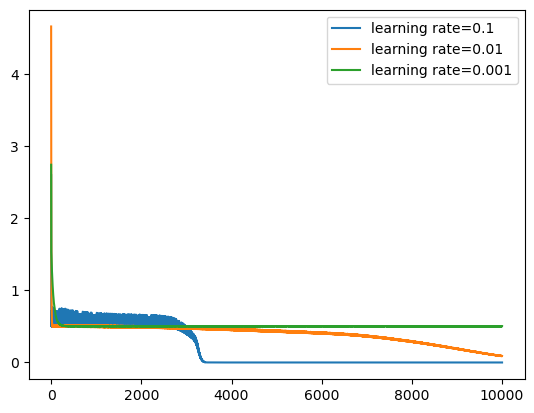

In [82]:
# Ploteamos los resultados
plt.figure()
plt.plot(resultados_lr1, label='learning rate=0.1')
plt.plot(resultados_lr2, label=f'learning rate={lr2}')
plt.plot(resultados_lr3, label=f'learning rate={lr3}')
plt.legend()
plt.show()

- Se ve en este caso que con un learning rate mayor, converge más rápido.
- Se prueban varias corridas y existe una diferencia de las convergencias.

## Planteamos modelo XOR con PyTorch

In [21]:
# Definimos los tensores de entrada para usarse en los modelos
X = torch.tensor([
    [0, 0], 
    [0, 1], 
    [1, 0], 
    [1, 1]], dtype=torch.float32)
y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

In [22]:
# Para hacer el planteo con PyTorch, es necesario realizar una clase y heredarla de torch nn.Module
class ModeloXOR(nn.Module): # https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    # Definimos la función init donde generamos los tipos de red
    def __init__(self):
        # Hereda el constructor de nn.Module
        super(ModeloXOR, self).__init__()
        
        # Generamos las capas que se usarán
        self.capa1 = nn.Linear(in_features=2, out_features=2) # Las salidas y entradas son 2
        self.capa2 = nn.Linear(in_features=2, out_features=1) # recibe las dos entradas y genera la salida
        
    # Definimos la función forward, que tendrá una acticación sigmoide en la primera capa
    def forward(self, entrada):
        # La primera salida lleva la aplicación de una sigmoide y la segunda la identidad
        salida1 = nn.functional.sigmoid(self.capa1(entrada)) # https://pytorch.org/docs/stable/generated/torch.nn.functional.sigmoid.html
        salida2 = self.capa2(salida1)
        return salida2

In [23]:
# Una vez ya definida, podemos generar una instancia del modelo
modelo = ModeloXOR()
modelo

ModeloXOR(
  (capa1): Linear(in_features=2, out_features=2, bias=True)
  (capa2): Linear(in_features=2, out_features=1, bias=True)
)

In [24]:
# En este caso en particular, debemos calcular como criterio de pérdida MSE y como optimizador un SGD
funcion_perdida = nn.MSELoss() # https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html
optimizador = torch.optim.SGD(modelo.parameters(), lr=0.1) # https://pytorch.org/docs/stable/generated/torch.optim.SGD.html

In [25]:
# El entrenamiento se produce siguiendo las indicaciones de los ejemplos de la documentación

# Definimos un número de epochs
epochs = 20000
for epoch in range(epochs):
    # Hacemos el forward propagation
    salidas = modelo(X)
    perdida = funcion_perdida(salidas, y)
    
    # Hacemos el backward propagation que ya incluye la actualización de los parámetros
    optimizador.zero_grad() # https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html -> resetea los gradientes
    perdida.backward() # https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944
    optimizador.step() # re evalua el modelo
    
    # Imprimimos las epochs
    if (epoch % (epochs/10)) == 0:
        print(f'Epoch [{epoch}/{epochs}], Pérdida: {perdida.item()}')

Epoch [0/20000], Pérdida: 0.2816257178783417
Epoch [2000/20000], Pérdida: 0.24991577863693237
Epoch [4000/20000], Pérdida: 0.2446751445531845
Epoch [6000/20000], Pérdida: 0.013914259150624275
Epoch [8000/20000], Pérdida: 3.866773568006465e-11
Epoch [10000/20000], Pérdida: 3.4990677022506134e-11
Epoch [12000/20000], Pérdida: 3.4990677022506134e-11
Epoch [14000/20000], Pérdida: 3.4990677022506134e-11
Epoch [16000/20000], Pérdida: 3.4990677022506134e-11
Epoch [18000/20000], Pérdida: 3.4990677022506134e-11


In [26]:
# En este caso en particular, debemos calcular como criterio de pérdida MSE y como optimizador un minibatch
funcion_perdida = nn.MSELoss() # https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html
optimizador = torch.optim.Adam(modelo.parameters(), lr=0.1) # https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

In [27]:
# El entrenamiento se produce siguiendo las indicaciones de los ejemplos de la documentación

# Definimos un número de epochs
epochs = 20000
for epoch in range(epochs):
    # Hacemos el forward propagation
    salidas = modelo(X)
    perdida = funcion_perdida(salidas, y)
    
    # Hacemos el backward propagation que ya incluye la actualización de los parámetros
    optimizador.zero_grad() # https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html -> resetea los gradientes
    perdida.backward() # https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944
    optimizador.step() # re evalua el modelo
    
    # Imprimimos las epochs
    if (epoch % (epochs/10)) == 0:
        print(f'Epoch [{epoch}/{epochs}], Pérdida: {perdida.item()}')

Epoch [0/20000], Pérdida: 3.4990677022506134e-11
Epoch [2000/20000], Pérdida: 0.0
Epoch [4000/20000], Pérdida: 0.0
Epoch [6000/20000], Pérdida: 0.0
Epoch [8000/20000], Pérdida: 0.0
Epoch [10000/20000], Pérdida: 0.0
Epoch [12000/20000], Pérdida: 0.0
Epoch [14000/20000], Pérdida: 0.0
Epoch [16000/20000], Pérdida: 0.0
Epoch [18000/20000], Pérdida: 0.0
